In [17]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint
import json
# https://wiki.python.org/moin/UsingPickle
import pickle

pp = pprint.PrettyPrinter(width=120, compact=True)


# Load Patient Case Descriptions

In [18]:
Queries = "topics-2014_2015-summary.topics"
Qrels = "qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)
cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

eval = trec.TrecEvaluation(cases, Qrels)
pp.pprint(cases)

{'20141': '58-year-old woman with hypertension and obesity presents with exercise-related episodic chest pain '
          'radiating to the back.\n'
          '       \t\t',
 '201410': '67-year-old woman status post cardiac catheterization via right femoral artery, now with a cool, pulseless '
           'right foot and right femoral bruit.\n'
           '       \t\t',
 '201411': '40-year-old woman with severe right arm pain and hypotension. She has no history of trauma and right arm '
           'exam reveals no significant findings.\n'
           '       \t\t',
 '201412': '25-year-old woman with fatigue, hair loss, weight gain, and cold intolerance for 6 months.\n       \t\t',
 '201413': '30-year-old woman who is 3 weeks post-partum, presents with shortness of breath, tachypnea, and hypoxia.\n'
           '       \t\t',
 '201414': '85-year-old man who was in a car accident 3 weeks ago, now with 3 days of progressively decreasing level '
           'of consciousness and impaired abili

# Define Clinical Trial Document Structure

In [29]:

class Trial:
    _nct_id : str
    _brief_title : str
    _detailed_description : str
    _brief_summary : str
    _criteria : str
    _phase : str
    _study_type : str
    _study_design : str
    _condition : str
    _intervention : {}
    _gender : str
    _min_age : int
    _max_age : int
    _healthy_volunteers : str
    _mesh_terms : []

    def __init__(self):
        self._nct_id = ""
        self._intervention = {}
        self._mesh_terms = []

    def show(self):
        print(json.dumps(self.__dict__, indent=4))

def cleanstr(txt):
    return re.sub(' +', ' ', txt.strip().replace('\n',''))


# Load the clinical trials

In [23]:
import xml.etree.ElementTree as ET
import tarfile
import re

tar = tarfile.open("/data/courses_data/clinical_trials/clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
i = 0
ids = []
full_docs = []
for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True

        if judged is False:
            continue

        i = i + 1

        trial = Trial()
        
        for brief_title in root.iter('brief_title'):
            ids.append(doc_id.text)
            trial._nct_id = cleanstr(doc_id.text)
            trial._brief_title = cleanstr(brief_title.text)

        trial._detailed_description = trial._brief_title
        for detailed_description in root.iter('detailed_description'):
            for child in detailed_description:
                trial._detailed_description = cleanstr(child.text)

        trial._brief_summary = trial._brief_title
        for brief_summary in root.iter('brief_summary'):
            for child in brief_summary:
                trial._brief_summary = cleanstr(child.text)

        trial._criteria = trial._brief_title
        for criteria in root.iter('criteria'):
            for child in criteria:
                trial._criteria = cleanstr(child.text)
                
        trial._brief_summary = trial._brief_title
        for phase in root.iter('phase'):
            trial._phase = cleanstr(phase.text)

        for study_type in root.iter('study_type'):
            trial._study_type = cleanstr(study_type.text)
            
        for study_design in root.iter('study_design'):
            trial._study_design = cleanstr(study_design.text)
            
        trial._condition = trial._brief_title
        for condition in root.iter('condition'):
            trial._condition = cleanstr(condition.text)

        for interventions in root.iter('intervention'):
            for child in interventions:
                trial._intervention[cleanstr(child.tag)] = cleanstr(child.text)

        trial._gender = "both"
        for gender in root.iter('gender'):
            trial._gender = cleanstr(gender.text)
            
        trial._minimum_age = 0
        for minimum_age in root.iter('minimum_age'):
            age = re.findall('[0-9]+', cleanstr(minimum_age.text))
            if age:
                trial._minimum_age = int(age[0])
            else:
                trial._minimum_age = 0
            
        trial._maximum_age = 150
        for maximum_age in root.iter('maximum_age'):
            age = re.findall('[0-9]+', cleanstr(maximum_age.text))
            if age:
                trial._maximum_age = int(age[0])
            else:
                trial._maximum_age = 150
               
            
        trial._healthy_volunteers = trial._brief_title
        for healthy_volunteers in root.iter('healthy_volunteers'):
            trial._healthy_volunteers = cleanstr(healthy_volunteers.text)
            
        for mesh_term in root.iter('mesh_term'):
            trial._mesh_terms.append(cleanstr(mesh_term.text))
        
        full_docs.append(trial)
        
tar.close()

print("Total of clinical trials: ", i)

pickle.dump(ids, open( "doc_ids.bin", "wb" ) )
pickle.dump(full_docs, open( "full_documents.bin", "wb" ) )


Total of clinical trials:  3626


In [ ]:
# Example of a document
pp.pprint(vars(full_docs[0]))

# Retrieval Models

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix

class VSMindex:

    def __init__(self, corpus, _ngram_range=(1,1), _analyzer='word', _stop_words = None):

        # TO DO: Compute the indexing matrices
        
        return

    def search(self, query):
        
        # TO DO: Compute retrieval scores for all documents
        
        return doc_scores


class LMJMindex:
    
    def __init__(self, corpus, _ngram_range=(1,1), _analyzer='word', _stop_words = None):

        # TO DO: Compute the indexing matrices

        return

    def set_params(self, params):
        if 'lambda' in params:
            self.lbd = params['lambda']
            self._log_lmjm = np.log(self.lbd * self.prob_term_doc + (1-self.lbd) * self.prob_term_col)
            print("LMJM lambda ", self.lbd)

    def search(self, query):

        # TO DO: Compute retrieval scores for all documents

        return doc_scores



# Indexing

In [4]:
import pickle
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )

corpus_brief_title = []
corpus_brief_summary = []
corpus_detailed_description = []
corpus_criteria = []
corpus_full = []
for trial in full_docs:
    corpus_brief_title.append(trial._brief_title)
    corpus_brief_summary.append(trial._brief_summary)
    corpus_detailed_description.append(trial._detailed_description)
    corpus_criteria.append(trial._criteria)

    full = trial._brief_title + trial._brief_summary + trial._detailed_description + trial._criteria
    corpus_full.append(full)

indexes_list = {}

indexes_list['vsm_brief_title'] = VSMindex(corpus_brief_title, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['vsm_brief_summary'] = VSMindex(corpus_brief_summary, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['vsm_detailed_description'] = VSMindex(corpus_detailed_description, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['vsm_criteria'] = VSMindex(corpus_criteria, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['vsm_full'] = VSMindex(corpus_full, _ngram_range=(1,1), _analyzer='word', _stop_words = None)

indexes_list['lmjm_brief_title'] = LMJMindex(corpus_brief_title, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['lmjm_brief_summary'] = LMJMindex(corpus_brief_summary, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['lmjm_detailed_description'] = LMJMindex(corpus_detailed_description, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['lmjm_criteria'] = LMJMindex(corpus_criteria, _ngram_range=(1,1), _analyzer='word', _stop_words = None)
indexes_list['lmjm_full'] = LMJMindex(corpus_full, _ngram_range=(1,1), _analyzer='word', _stop_words = None)

pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )


### Helper code to calibrate parameters

In [ ]:
import trec
params = {}
avg_precision_11point = np.zeros(11)
for lbd in [0, 0.05, 0.1, 0.3, 0.5, 0.6, 0.8, 0.9]:
    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    index = indexes_list['lmjm_full']
    params['lambda'] = lbd
    index.set_params(params)
    for caseid in cases:
        query = cases[caseid]
        doc_scores = index.search(query)

        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall
    
    m_ap = m_ap / len(cases)
    m_p10 = m_p10 / len(cases)
    m_mrr = m_mrr / len(cases)
    m_ndcg5 = m_ndcg5 / len(cases)
    m_recall = m_recall / len(cases)
    print("   MAP    ", m_ap)
    print("   MRR    ", m_mrr)
    print("   P10    ", m_p10)
    print("   NDCG@5 ", m_ndcg5)
    print("   Recall ", m_recall)

# Retrieval

In [6]:
for index_name in indexes_list:
    print()
    print(index_name)
    index = indexes_list[index_name]
    index.doc_scores = {}
    index.results_ord = {}
    for caseid in cases:
        query = cases[caseid]

        doc_scores = index.search(query)

        index.doc_scores[caseid] = doc_scores
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        index.results_ord[caseid] = results.sort_values(by=['score'], ascending = False)

    indexes_list[index_name] = index

pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )



vsm_brief_title

vsm_brief_summary

vsm_detailed_description

vsm_criteria

vsm_full

lmjm_brief_title

lmjm_brief_summary

lmjm_detailed_description

lmjm_criteria

lmjm_full


## Filters

In [4]:
import re
test = False

def filter_by_age_and_gender(doc_scores, query):

    # TO DO: Implement filters by age and gender

    return doc_scores



------------------------------
# Compute evaluation metric results
For each patient, search each index and rank clinical trials by their similarity to the patient case description

In [5]:
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )
indexes_list = pickle.load( open( "indexes_list.bin", "rb" ) )


In [13]:
import copy

for index_name in indexes_list:
    index = indexes_list[index_name]
    print()
    print(index_name)

    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    mean_precision_11point = np.zeros(11)
    
    index.p10_per_query = {}
    index.p10_per_query = {}
    index.ndcg5_per_query = {}
    index.recall_per_query = {}
    index.mrr_per_query = {}
    index.ap_per_query = {}
    index.precision_11point_per_query = {}

    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        #p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        if (np.shape(recall_11point) != (0,)):
            mean_precision_11point = mean_precision_11point + precision_11point
        
        index.p10_per_query[caseid] = p10
        index.ndcg5_per_query[caseid] = ndcg5
        index.recall_per_query[caseid] = recall
        index.mrr_per_query[caseid] = mrr
        index.ap_per_query[caseid] = ap
        index.precision_11point_per_query[caseid] = precision_11point

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall

    index.m_ap = m_ap / len(cases)
    index.m_p10 = m_p10 / len(cases)
    index.m_mrr = m_mrr / len(cases)
    index.m_ndcg5 = m_ndcg5 / len(cases)
    index.m_recall = m_recall / len(cases)
    index.mean_precision_11point = mean_precision_11point/len(cases)

    print("   P10    ", index.m_p10)
    print("   NDCG@5 ", index.m_ndcg5)
    print("   MRR    ", index.m_mrr)
    print("   MAP    ", index.m_ap)
    print("   Recall ", index.m_recall)

    indexes_list[index_name] = index

pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )



vsm_brief_title
   MAP     0.043948954280774395
   MRR     0.005169818729140765
   P10     0.06949152542372884
   NDCG@5  0.0639430111212793
   Recall  1.0

vsm_brief_summary
   MAP     0.043948954280774395
   MRR     0.005169818729140765
   P10     0.06949152542372884
   NDCG@5  0.0639430111212793
   Recall  1.0

vsm_detailed_description
   MAP     0.069005097130316
   MRR     0.005169818729140765
   P10     0.1220338983050847
   NDCG@5  0.10194286148324694
   Recall  1.0

vsm_criteria
   MAP     0.06653160906259249
   MRR     0.005169818729140765
   P10     0.1050847457627118
   NDCG@5  0.11918891719170586
   Recall  1.0

vsm_full
   MAP     0.09512713707715933
   MRR     0.005169818729140765
   P10     0.13050847457627118
   NDCG@5  0.1300229523447014
   Recall  1.0

lmjm_brief_title
   MAP     0.04218579747041739
   MRR     0.005169818729140765
   P10     0.05762711864406782
   NDCG@5  0.04914351410821713
   Recall  1.0

lmjm_brief_summary
   MAP     0.04218579747041739
   MRR    

In [15]:
pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )


-------------------------
This is evaluation has fewer metrics (it is faster)

In [37]:
import copy

for index_name in indexes_list:
    index = indexes_list[index_name]
    print()
    print(index_name)
    avg_precision_11point = np.zeros(11)
    m_p10 = 0
    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        #[precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        #if (np.shape(recall_11point) != (0,)):
        #    avg_precision_11point = avg_precision_11point + precision_11point

        m_p10 = m_p10 + p10
    m_p10 = m_p10 / len(cases)
    print("   P10 ", m_p10)



rm3_brief_title
   P10  0.0016949152542372883


# Fusion RRF

In [162]:
import copy

reciprocal = 1/(np.arange(1, len(full_docs)+1)-0)
rrf = {}
for caseid in cases:
    rrf[caseid] = np.zeros([len(full_docs),1])
for index_name in indexes_list:
    index = indexes_list[index_name]
    for caseid in cases:
        doc_scores = index.doc_scores[caseid]
        perm_forward = np.argsort(-doc_scores, axis = 0)
        perm_back = np.argsort(perm_forward, axis = 0)
        rrf[caseid] = rrf[caseid] + reciprocal[perm_back]

m_p10 = 0
for caseid in cases:
    doc_scores = rrf[caseid]
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    p10 = eval.fast_p10(results_ord, caseid)
        
    m_p10 = m_p10 + p10
m_p10 = m_p10 / len(cases)
print("   P10 ", m_p10)


   P10  0.13389830508474573


# Results and discussion

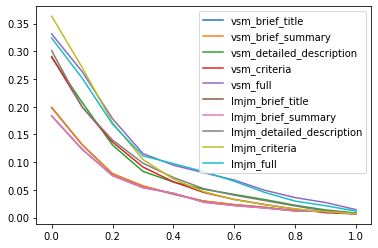

In [21]:
#ids = pickle.load( open( "doc_ids.bin", "rb" ) )
#full_docs = pickle.load( open( "full_documents.bin", "rb" ) )
#indexes_list = pickle.load( open( "indexes_results.bin", "rb" ) )

import matplotlib.pyplot as plt

recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for index_name in indexes_list:
    index = indexes_list[index_name]
    plt.plot(recall_11point,index.mean_precision_11point, label = index_name)
    plt.legend()

plt.show()



In [56]:
import pandas as pd

results_table = pd.DataFrame(columns =['model', 'p10', 'ndcg5', 'mrr', 'map', 'recall'])
for index_name in indexes_list:
    index = indexes_list[index_name]
    aa = pd.DataFrame({'model':[index_name], 'p10':[index.m_p10], 'ndcg5':[index.m_ndcg5], 'mrr': [index.m_mrr], 'map':[index.m_ap], 'recall':[index.m_recall]})
    results_table = results_table.append(aa, ignore_index=False)

results_table


,model,p10,ndcg5,mrr,map,recall
0,vsm_brief_title,0.069492,0.063943,0.00517,0.043949,1.0
0,vsm_brief_summary,0.069492,0.063943,0.00517,0.043949,1.0
0,vsm_detailed_description,0.122034,0.101943,0.00517,0.069005,1.0
0,vsm_criteria,0.105085,0.119189,0.00517,0.066532,1.0
0,vsm_full,0.130508,0.130023,0.00517,0.095127,1.0
0,lmjm_brief_title,0.057627,0.049144,0.00517,0.042186,1.0
0,lmjm_brief_summary,0.057627,0.049144,0.00517,0.042186,1.0
0,lmjm_detailed_description,0.106780,0.115677,0.00517,0.070558,1.0
0,lmjm_criteria,0.122034,0.142342,0.00517,0.079018,1.0
0,lmjm_full,0.152542,0.136432,0.00517,0.093162,1.0


<BarContainer object of 59 artists>

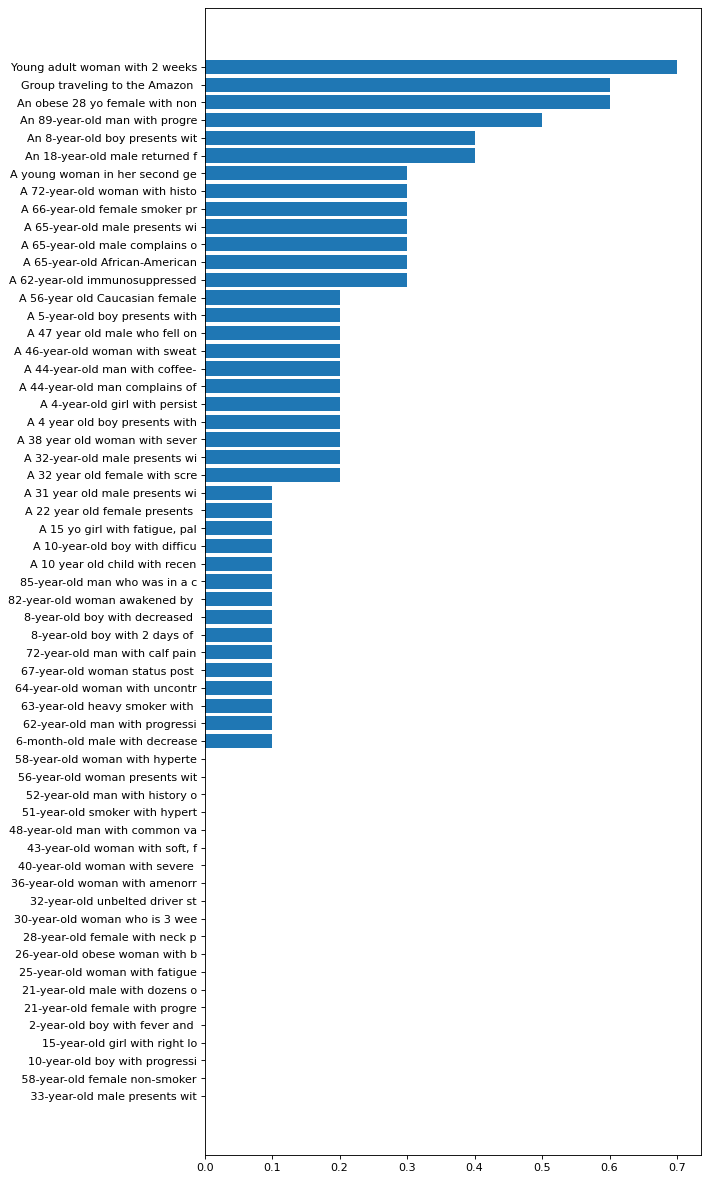

In [86]:
from matplotlib.pyplot import figure
index = indexes_list['lmjm_full']

query_result = np.sort([index.p10_per_query[caseid] for caseid in cases ])
query_text = np.sort([cases[caseid][0:30] for caseid in cases ])

figure(figsize=(8, 19), dpi=80)

plt.barh(query_text, query_result)